In [13]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

In [14]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [15]:
# Генерация данных
seq_length = 50
time_steps = np.linspace(0, 4 * np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1))


In [16]:
x = data[:-1]
y = data[1:]

In [17]:
x_tensor = torch.Tensor(x).unsqueeze(0)
y_tensor = torch.Tensor(y)

In [18]:
# Определение модели RNN
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden


In [19]:
# Параметры модели
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

rnn = RNN(input_size, output_size, hidden_dim, n_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)


In [20]:
# Обучение модели
n_epochs = 200
hidden = None
for epoch in range(n_epochs):
    optimizer.zero_grad()
    output, hidden = rnn(x_tensor, hidden)
    hidden = hidden.data
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.4934339225292206
Epoch 20, Loss: 0.007266991771757603
Epoch 40, Loss: 0.0014988946495577693
Epoch 60, Loss: 0.014897669665515423
Epoch 80, Loss: 0.0032931205350905657
Epoch 100, Loss: 0.0007349677616730332
Epoch 120, Loss: 0.0003843888989649713
Epoch 140, Loss: 0.00022598840587306768
Epoch 160, Loss: 0.00013756929547525942
Epoch 180, Loss: 7.871193520259112e-05


In [21]:
# Прогнозирование
predicted, _ = rnn(x_tensor, None)
predicted = predicted.detach().numpy()


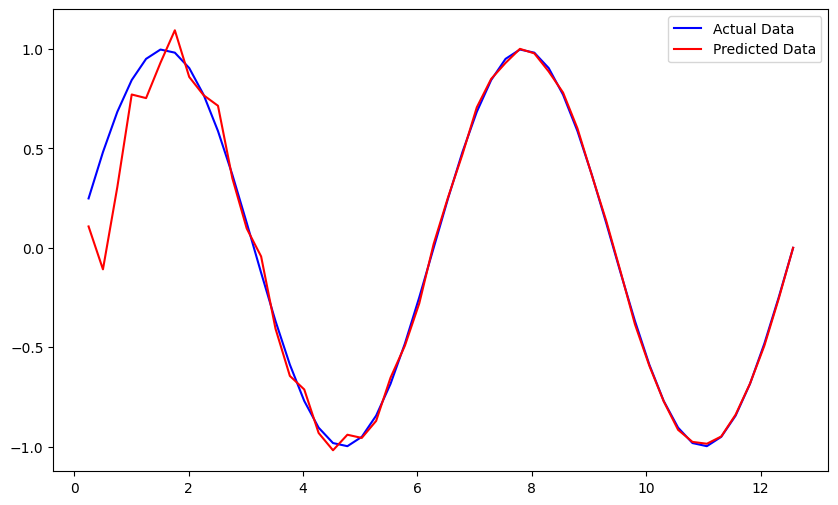

In [22]:
# Визуализация реальных данных и прогнозов
plt.figure(figsize=(10, 6))
plt.plot(time_steps[1:], y, 'b-', label="Actual Data")
plt.plot(time_steps[1:], predicted.flatten(), 'r-', label="Predicted Data")
plt.legend()
plt.show()

In [23]:
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.

In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [25]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [26]:
# Загрузка данных
data = pd.read_csv('ETTm1.csv', parse_dates=['date'], index_col='date')
series = data['OT'].values


In [27]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(-1, 1))
series_normalized = scaler.fit_transform(series.reshape(-1, 1))


In [28]:
# Подготовка данных для LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [29]:
seq_length = 10
x, y = create_sequences(series_normalized, seq_length)


In [30]:
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()


In [31]:
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [32]:
# Параметры модели
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 1


In [33]:
# Инициализация модели, функции потерь и оптимизатора
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [34]:
# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    for x_batch, y_batch in dataloader:
        outputs = model(x_batch)
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003


In [36]:
# Предсказание
model.eval()
with torch.no_grad():
    test_inputs = series_normalized[-seq_length:]
    test_inputs = torch.from_numpy(test_inputs).float().unsqueeze(0)
    predicted = model(test_inputs).detach().numpy()
    predicted = scaler.inverse_transform(predicted)

print(f'Предсказанное значение: {predicted[0][0]}')

Предсказанное значение: 9.916807174682617
